In [0]:
# Copyright (c) Facebook, Inc. and its affiliates.
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Env

In [0]:
class BasicEnv():

  # A simple MDP: X = R^{noise_dims + true_dims}
  def __init__(self, true_dims, noise_dims, noise_mean=None):
    self.true_dims = true_dims
    self.noise_dims = noise_dims
    self.dim = true_dims + noise_dims
    if noise_mean is None:
      self.r_vec = 0.5 * np.concatenate([np.ones(self.true_dims), np.zeros(self.noise_dims)])
    else:
      self.r_vec = 0.5 * np.concatenate([np.ones(self.true_dims), np.ones(self.noise_dims) * noise_mean])

  def reset(self):
    self.state = np.random.normal(np.zeros(self.dim ))
  
  def step(self, action):
    # Note that for experiments, we set r_vec[noise_dims] = 0
    reward = np.dot(self.r_vec, self.state)
    # In this MDP, we allow for noise_dims at time t to depend on time t-1
    self.state = self.state + action * np.ones(self.dim) + np.random.normal(np.zeros(self.dim), scale=0.01)
    
    return self.state, reward


# Models

In [0]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()

        #parameters 

        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU())
        self.fc = nn.Linear(256, out_dim)

    def forward(self, x):
        dim = x.shape[0]
        x = x.reshape([dim, -1])
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out 

class LinearNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearNet, self).__init__()

        #parameters 
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        out = self.fc(x)
        return out 

# Agent

In [0]:
class Learner():
  # An agent which learns a model of the MDP
  def __init__(self, state_dim, latent_dim=None):
    self.state_dim = state_dim
    if latent_dim is None:
      self.latent_dim = state_dim
    else:
      self.latent_dim = latent_dim
    self.phi = LinearNet(self.state_dim, self.latent_dim)
    self.reward_model = LinearNet(self.latent_dim + 1, 1)
    self.transition_model = MLP(self.latent_dim + 1, self.latent_dim)
    self.reward_opt = torch.optim.SGD(self.reward_model.parameters(), lr=0.001)
    self.transition_opt = torch.optim.SGD(self.transition_model.parameters(), lr=0.001)
    self.phi_opt = torch.optim.SGD(self.phi.parameters(), lr=0.001)

  def predict_next_embedding(self, state, action):
    combined_s = torch.cat([self.phi(state), action]).reshape([1, self.latent_dim+1])
    return self.transition_model(combined_s)
  
  def predict_reward(self, state, action):

    inputs = torch.cat([self.phi(state), action])

    inputs = inputs.reshape([1, self.latent_dim + 1])

    r_pred = self.reward_model(inputs)

    return r_pred

  def train_step(self, s, action, reward, s_next):
    pred_r = self.predict_reward(s_next, action)

    reward_loss = torch.nn.MSELoss()(pred_r, torch.Tensor([reward]))
    step_loss = torch.nn.MSELoss()(self.predict_next_embedding(s, action),
                                   self.phi(torch.Tensor(s_next)))
    self.transition_model.zero_grad()
    self.reward_model.zero_grad()
    self.phi.zero_grad()
    reward_loss.backward()
    step_loss.backward()
    self.reward_opt.step()
    self.transition_opt.step()
    self.phi_opt.step()
    return reward_loss, step_loss



In [0]:
n_true = 3
n_noise = 6

env = BasicEnv(n_true, n_noise)
learner = Learner(n_true + n_noise, n_true)
r_losses = []
s_losses = []

In [0]:
def train_on_envs(learner, envs, episode_length=10, num_episodes=100):
  # Reset all environments to init
  for env in envs:
    env.reset()
  
  r_losses = [[] for _ in envs]
  s_losses = [[] for _ in envs]
  curr_episode = 0
  while(curr_episode < num_episodes):
    for env in envs:
      env.reset()
    for step in range(10):
      for i, env in enumerate(envs):
        # We perform policy evaluation on the uniform random policy.
        a = np.random.choice([-1,1])
        s = torch.Tensor(env.state)
        s_next, r = env.step(a)
        rl, sl = learner.train_step(s, torch.Tensor([a]), r, torch.Tensor(s_next))

        # Logging
        r_losses[i].append(rl)
        s_losses[i].append(sl)
    curr_episode +=1
  return r_losses, s_losses

  
  

# ICP


In [0]:
# ICP Algorithm: based off https://github.com/jan-glx/ICPy/

import itertools as it
from collections import namedtuple

import numpy as np
import scipy.stats
import sklearn.linear_model


def all_parent_sets(S, max_num_parents):
    return it.chain.from_iterable(
        it.combinations(S, n_parents) for n_parents in range(min(len(S), max_num_parents) + 1))


def f_test(x1, x2):
    """
    Perform F-test for equal variance.
    """
    F = np.var(x1, ddof=1) / np.var(x2, ddof=1)
    return 2 * min(scipy.stats.f.cdf(F, len(x1) - 1, len(x2) - 1), scipy.stats.f.sf(F, len(x1) - 1, len(x2) - 1))


def test_plausible_parent_set(X, y, z):
    n_e = np.max(z) + 1
    lm = sklearn.linear_model.LinearRegression(fit_intercept=False)
    X_with_intercept = np.hstack((X, np.ones((X.shape[0], 1))))
    lm.fit(X_with_intercept, y)
    residuals = lm.predict(X_with_intercept) - y 
    #print(lm.coef_, 'coefficient')
    #print(' residuals variance: ', np.var(residuals))
    var_p = 1
    mean_p = 1
    for e in range(n_e):
      #print('means: ', np.mean(residuals[np.equal(z, e)]), np.mean(residuals[np.logical_not(np.equal(z,e))]))
      a = scipy.stats.ttest_ind(residuals[np.equal(z, e)],
                                                residuals[np.logical_not(np.equal(z, e))],
                                                equal_var=False).pvalue
      mean_p = min(mean_p, a)
      b = f_test(residuals[np.equal(z, e)],
                                residuals[np.logical_not(np.equal(z, e))])
      var_p = min(var_p, b)

    # print(var_p, mean_p, 'p vals')
    return max(mean_p, var_p) * n_e



def preselect_parents(X, y, n):
    _, selected, _ = sklearn.linear_model.lars_path(X, y, method='lasso', max_iter=n, return_path=False)
    return selected


ICP = namedtuple("ICP", ["S_hat", "q_values", "p_value"])


def invariant_causal_prediction(X, y, z, alpha=0.1):
    """
    Perform Invariant Causal Prediction.
    Thanks to @jan-glx (https://github.com/jan-glx/ICPy/blob/master/icpy/ICP.py)
    Parameters
    ----------
    X : (n, p) ndarray
        predictor variables
    y : (n,) ndarray
        target variable, numpy array of shape `(n)`
    Z : array_like
        index of environment, length(Z)==`n`
    alpha : float
        Confidence level of the tests and FDR to control. P(\hat{S} \subset S^*) \gte 1-`alpha`
    Returns
    -------
    list
        The identified causal parent set, \hat{S}, as list of indices
    """

    n = X.shape[0]
    p = X.shape[1]

    max_num_parents = 8

    S_0 = list(range(p))
    q_values = np.zeros(p)
    p_value_model = 0
    includes = np.zeros(len(list(all_parent_sets(S_0, max_num_parents))))
    i = 0
    for S in all_parent_sets(S_0, max_num_parents):
        # print('set: ', S)
        not_S = np.ones(p, np.bool)
        not_S[list(S)] = False
        p_value = test_plausible_parent_set(X[:, S], y, z)
        q_values[not_S] = np.maximum(q_values[not_S], p_value)
        p_value_model = max(p_value_model, p_value)
        includes[i] = 1 if p_value > alpha else 0
        # print(includes)
        i += 1

    q_values = np.minimum(q_values, 1)
    # print('q values', q_values, np.where(q_values <= alpha))
    S_hat = np.where(q_values <= alpha)[0]

    return ICP(S_hat, q_values, p_value_model)

In [0]:
# ICP for RL algorithm

# Find causal parents of reward T

# queue S <- T
# set AN = []
# while S not empty:
# t <- s.dequeue()
# if t in AN:
#   continue 
# AN.append(t)
# P <- causal parents(t)
# S.enqueue(P)
# return AN

def causal_states(buffer, alpha=0.1):
  # transition_buffer := [ [(s, a, r, s'), e] ]
  causal_vars = []
  
  states = np.array([b[0][0] for b in buffer])
  rewards = np.array([b[0][2] for b in buffer])
  envs = np.array([b[1] for b in buffer])
  envs = envs.astype(np.int32)
  dims = states.shape[1]
  r_parents = list(invariant_causal_prediction(states, rewards, envs, alpha/dims)[0])
  #print(r_parents)
  q = r_parents.copy()
  an = []
  while (not len(q) == 0):
    n = q[0]
    q = q[1:]
    if n in an:
      continue
    else:
      an.append(n)
      # print(n)
      nexts = np.array([b[0][3][n] for b in buffer])
      parents = invariant_causal_prediction(states, nexts, envs)[0]
      for p in parents:
        q.append(p)
  return an 






# Policy Evaluation Code

In [0]:
def generate_replay_buffer(n_samples):
  dim = 3
  b = []
  for i in range(n_samples):
    s = np.random.rand(dim) * 10.0
    s[0] = 1.0
    r = s[1] # + np.random.rand() - 0.5
    s_next = [s[0], s[0] + np.random.rand() - 0.5, s[2] + np.random.rand() - 0.5]
    b.append( [[s, 0, r, s_next], 0])

  for i in range(n_samples):
    s = np.random.rand(dim)
    r = s[1] + np.random.rand() - 0.5
    s_next = [s[0] + np.random.rand()-0.5, s[0], s[2] + np.random.rand() - 0.5]
    b.append( [[s, 0, r, s_next], 1])

  for i in range(n_samples):
    s = np.random.rand(dim)
    s[2] = 20
    r = s[1] + np.random.rand() - 0.5
    s_next = [s[0] + np.random.rand()-0.5, s[0] + np.random.rand() - 0.5 , s[2]]
    b.append( [[s, 0, r, s_next], 2])
  

  return b 

def adversarial_replay_buffer(num_samples, x3=-1): 
  for i in range(num_samples):
    dim = 3
    b = []
    s = np.random.rand(dim)
    r = s[1] + np.random.rand() - 0.5 
    s[2] = x3
    s_next = [s[0] + np.random.rand()-0.5, s[0] + np.random.rand() - 0.5 , s[2]]
    b.append( [[s, 0, r, s_next], 2])
  return b

In [73]:
def train_linear_predictor(data, gamma=0.99):
  """ Train a linear predictor on a given replay buffer
  """

  n = len(data)
  dim = len(data[0][0][0])
  pred = np.ones(dim)
  for e in range(100):
    idx = np.random.choice(len(data), 1)[0]

    s,a,r,snext = data[idx][0]
    ypred = np.dot(pred, s)
    target = gamma*np.dot(pred, snext) + r 
    grad = s * (target - ypred)
    pred = pred + 0.01 * grad 
  return pred

def get_bellman_error(data, w, gamma=0.99):
  cum_err = 0
  for d in data:
    err = (np.dot(d[0][0], w) + d[0][2] + gamma * np.dot(d[0][3], w))**2
    cum_err += err
  
  return cum_err/len(data)

d = generate_replay_buffer(1000)
d_orig = generate_replay_buffer(1000)


# Obtain causal variable indices: note alpha set to be very low
indices = causal_states(d, alpha=0.001)

# with p > 0.999, causal states = [0,1].
# However, there is a small chance that on a given run, might get [0,1,2]
# Print to verify that we get [0,1]
print('Causal states: ', indices)


# Construct replay buffer consisting only of causal variables
data = [np.array([s[0][0][i] for i in indices]) for s in  d]
data2 = [[s[0][3][i] for i in indices] for s in d]
for i, _ in enumerate(d):
  d[i][0][0] = data[i]
  d[i][0][3] = data2[i]

# Train one predictor on the causal variables
p = train_linear_predictor(d)

# Train the other on all variables
p_orig = train_linear_predictor(d_orig)

p_errs = []
orig_errs = []
interventions = [0, 1, 10, 100, 200, 300, 400, 500]
if len(indices) <= 2:
  p = np.concatenate([p, [0]])
for v in interventions:
  adv = adversarial_replay_buffer(200, v)
  
  p_errs.append( get_bellman_error(adv, p))
  orig_errs.append(get_bellman_error(adv, p_orig))

SyntaxError: ignored

In [0]:
# Repeat for confidence intervals
cum_p= []
cum_e = []

for _ in range(20):
  p_errs = []
  orig_errs = []
  interventions = [0.1 * i for i in range(25)]
  for v in interventions:
    adv = adversarial_replay_buffer(100, v)
    p_errs.append( get_bellman_error(adv, p))
    orig_errs.append(get_bellman_error(adv, p_orig) )
  cum_p.append(p_errs)
  cum_e.append(orig_errs)

In [0]:
x = 0
# Test how much the change in alpha affects significance of causal variable selection:
# for what fraction of samples do we include the spurious var in our causal state?
for _ in range(100):
  b = generate_replay_buffer(1000)
  causal_vars = causal_states(b)
  if 2 in causal_vars:
    x += 1
print('Fraction of abstractions with spurious variable: %f'%(x/100))


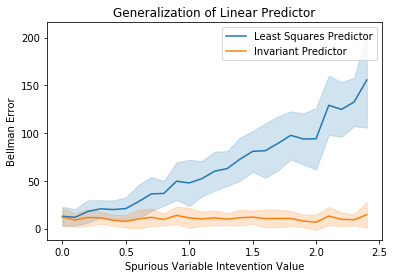

In [70]:
# Generate plots
import seaborn as sns
import pandas as pd

df = pd.DataFrame()
df['errs'] = np.concatenate(cum_e)

df['ts'] = np.concatenate([list(range(len(cum_e[0]))) for _ in range( len(cum_e))])
df['ts'] = 0.1 * df['ts']
sns.lineplot(x="ts", y="errs", data=df, ci="sd", label="Least Squares Predictor" )
df['t_errs'] = np.concatenate(cum_p)
sns.lineplot(x="ts", y="t_errs", data=df, ci="sd", label="Invariant Predictor")
plt.title('Generalization of Linear Predictor')
plt.xlabel('Spurious Variable Intevention Value')
plt.ylabel('Bellman Error')
plt.legend()


In [0]:
np.var(cum_e, axis=0)